In [137]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Thermodynamics 
By: Kristin Aoki and Sander Miller

How long can ice cream stay out of the freezer before bacteria growth becomes an issue?

Depending on the temperature outdoors, ice cream melts at varying time lengths. The goal of this model is to help people determine how long ice cream can be left outside the freezer at different temperatures. From our research, we gathered that ice cream cannot be returned to the freezer once it has reached 1.44 degrees Celsius.

To explore this equation we first establish the initial temperature of the ice cream as the state. We determined the initial temperature of the ice cream based on the average temperature of a freezer.

In [138]:
init = State(T=-17.778)

,values
T,-17.778


Next, we created a system with the parameters for the first order system. 
- r is equal to the specific heat capacity of ice cream 
- T_env is the temperature of the environment 
- t_end is the duration of the model
- dt is the time step.

In [139]:
ice_cream = System(init=init,
               r=0.0167,
               T_env=4.44,
               t_end=120,
               dt=1)

,values
init,T -17.778 dtype: float64
r,0.0167
T_env,4.44
t_end,120
dt,1


We created an update_func that calculates the temperature of the ice cream, based on Newton's Law of Cooling, for various times up until 120 minutes. After 120 minutes the ice cream can no longer be safely returned to the freezer.

In [140]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

Then, we created a run_simulation. We used a TimeFrame to run our update function from t=0 to t=120 and store the data in an array.

In [141]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T) 
    
    return frame

The first column in the table for results is time in minutes and the second column is temperature of the ice cream

In [142]:
results = run_simulation(ice_cream, update_func)

,T
0,-17.778000
1,-17.406959
2,-17.042115
3,-16.683364
4,-16.330604
5,-15.983735
6,-15.642658
7,-15.307278
8,-14.977498
9,-14.653226


We plotted the results of the TimeFrame with time on the x-axis and temperature in Celsius on the y-axis.

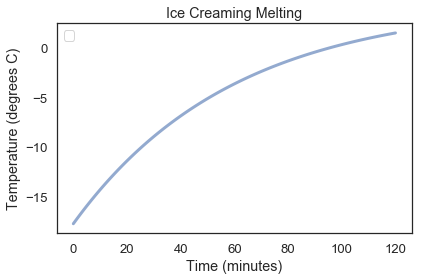

In [143]:
plot(results.T)
decorate(title='Ice Creaming Melting',
         xlabel='Time (minutes)',
         ylabel='Temperature (degrees C)')

The model shows us that at t=120 the ice cream reaches 1.49, thus it cannot return to the freezer. The flaw in this model is the temperature of the environment is a fixed number (4.44 degrees Celsius), and does not apply to all situations. The temperature of the environment depends upon where the ice cream is left out.

To solve this problem we will create a model that sweeps the temperature of the environment from 10 degrees Celsius to 43 degrees Celsius. Once again we begin with creating a state, but this time it is the inital time.

In [130]:
state=State(t=0)

,values
t,0


Next, we created a system similar to the original, but added temperature bounds for the environment and do not have a set end time.
- T_t is equal to the temperature at which ice cream can no longer return to the freezer
- r is equal to the specific heat capacity
- T_env0 is the lower bound temperature of the environment
- T_env_end is the upper bound temperature of the environment
- T is the initial temperature of the ice cream

In [131]:
system=System(state=state, T_t=1.44, r=0.0167, T_env0=10, T_env_end=44, T=-17.78)

,values
state,t 0 dtype: int64
T_t,1.44
r,0.0167
T_env0,10
T_env_end,44
T,-17.78


We created a new update_func that passes the system to solve for time. We dervived time by rearranging Newton's Law of Cooling.

In [132]:
def update_func2(state, T_env0, system):
    
    t=log((system.T_t-system.T_env0)/(system.T-system.T_env0))/-system.r
    
    return State(t=t)

Then we established a new run_simulation to store the new data in a TimeFrame. The first column sweeps environmental temperatures and the second column is the time to reach 1.44 degrees Celsius.

In [133]:
def run_simulation2(system, update_func2):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state"""
    
    frame = TimeFrame(columns=state.index)
    frame.row[10] = state
    ts = linrange(10, T_env_end)
    
    for system.T_env0 in ts:
        frame.row[system.T_env0] = update_func2(frame.row[10], system.T_env0, system)
        
    # store the final temperature in T_final
    system.t_final = get_last_value(frame.t) 
    
    return frame

In [134]:
results = run_simulation2(system, update_func2)

,t
10,70.491985
11,65.993591
12,62.081662
13,58.641573
14,55.588024
15,52.855946
16,50.394663
17,48.164011
18,46.131672
19,44.271295


Finally we plotted the data from the results table with temperature in Celsius on the x-axis and time in minutes on the y-axis.

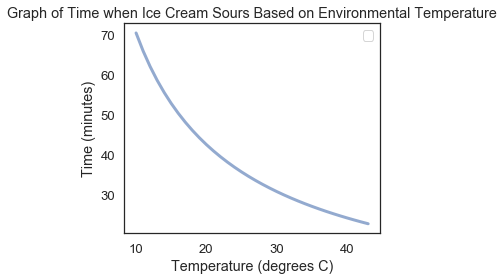

In [135]:
plot(results.t)
decorate(title='Graph of Time when Ice Cream Sours Based on Environmental Temperature',
         xlabel='Temperature (degrees C)',
         ylabel='Time (minutes)')

As temperature increase the time ice cream can remain out of the freezer decreases. The model is a non-linear function. 